In [1]:
from nn_mri import ImageFitting_set, SineLayer, get_mgrid, calculate_contrast, save_dicom
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray, gray2rgb
from torch import nn
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as sio
import os
import argparse

In [2]:
class case:
    def __init__(self, pt_id, erc, cancer_loc, contralateral_loc, noise, cancer_slice):
        '''
        class for a case
        pt_id : the patient id
        cancer_loc : cancer location pixel (center of a 3x3 region)
        contralateral_loc : mirror of the cancer location with is non-cancer
        cancer_slice : slice number where the cancer exists
        acquisitions : number of slices per X, Y, Z directions 
        '''
        
        self.pt_id = pt_id
        self.cancer_loc = cancer_loc
        self.contralateral_loc = contralateral_loc
        self.noise = noise
        self.cancer_slice = cancer_slice
        if erc:
            self.b = (0, 150, 1000, 1500)
        else:
            self.b = (0, 300, 600, 900)
        pt_no = self.pt_id.split('-')[-1]
        file_address = '/scratch/midway3/gundogdu/RECONSTRUCTION'
        filename = os.path.join(file_address, pt_no, 'no_aver', 'bigImage.mat')
        self.b0 = sio.loadmat(filename)['b0']
        self.b1 = sio.loadmat(filename)['b1']
        self.b2 = sio.loadmat(filename)['b2']
        self.b3 = sio.loadmat(filename)['b3']

                         
cases = []

cases.append(case('18-1681-07', 0, (67, 73), (63, 57), (80,65), 11))
cases.append(case('18-1681-08', 0, (80, 74), (77, 54), (97,65), 10))
cases.append(case('18-1681-09', 0, (62, 64), (56, 70), (76,62), 15))
cases.append(case('18-1681-30', 0, (67, 54), (66, 78), (84,64), 17))
cases.append(case('18-1681-37', 0, (68, 76), (71, 59), (80,67), 10))
cases.append(case('17-1694-82', 1, (56, 52), (56, 74), (80,60), 16))
cases.append(case('18-1681-41', 1, (69, 57), (69, 69), (86,65), 8))
cases.append(case('18-1694-76', 1, (73, 69), (73, 52), (90,64), 16))
cases.append(case('18-1681-45', 1, (71, 68), (65, 74), (87,62), 13))
cases.append(case('18-1694-78', 1, (62, 76), (63, 53), (78,60), 20))

In [3]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, 
                 hidden_layers, out_features, 
                 first_omega_0=30., 
                 hidden_omega_0=30.,
                 perturb=False):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))
        self.relu = nn.ReLU()
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))
        self.net.append(nn.Linear(hidden_features, hidden_features))
        self.net.append(nn.ReLU())
        self.final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        #self.net.append(final_linear)
        self.net = nn.Sequential(*self.net)
        self.perturb_linear = nn.Linear(3, hidden_features)
        self.perturb_linear2 = nn.Linear(hidden_features, out_features)
        self.tanh = nn.Tanh()  
        self.perturb = perturb
    def forward(self, coords, sample=0,eps=0):
        coords = coords.clone().detach().requires_grad_(False) # allows to take derivative w.r.t. input
        if self.perturb:
            acq = torch.tensor([sample], dtype=torch.float).cuda()
            acq = acq.repeat(coords.size(0),1)
            perturbation = self.perturb_linear(torch.cat((model_input, acq),-1))
            perturbation = self.tanh(perturbation)
            perturbation = self.perturb_linear2(perturbation)
            pertubation = eps*self.tanh(perturbation)
            coords = coords + pertubation
        output = self.net(coords)
        output = self.final_linear(output)
        output = self.relu(output)
        return output

In [4]:
eps = 1e-7
mag = 1000

def minmax_normalize(img, ref):

    return ((img - img.min())/(img.max() - img.min()))*(ref.max() - ref.min()) + ref.min()

def calc_adc(dwi, b0, b):
    adc = -np.log((dwi/(b0 + eps)) + eps)/b 
    return adc*mag

In [5]:
from csv import writer

In [6]:
def calculate_CNR_SNR(case, image):
    """ calculates the CNR and SNR based on cancer and the collateral benign tissue"""
    # cancer center x,y locations
    cc_x, cc_y = case.cancer_loc
    # contralateral benign x,y locations
    cb_x, cb_y = case.contralateral_loc
    # noise x,y locations
    cn_x, cn_y = case.noise
    cancer_area = image[cc_x - 1 : cc_x + 2, cc_y - 1 : cc_y + 2]
    contralateral_area = image[cb_x - 1 : cb_x + 2, cb_y - 1 : cb_y + 2]
    noise_area = image[cn_x - 2 : cn_x + 3, cn_y - 2 : cn_y + 3]
    
    #cancer_mean
    Sc = cancer_area.mean()
    #begign_mean
    Sb = contralateral_area.mean()
    #noise variance
    N = np.std(noise_area)
    
    SNRc = Sc/(N+1e-7)
    SNRb = Sb/(N+1e-7)
    CNR = abs(SNRc - SNRb)
    return np.log10(SNRc), np.log10(CNR), Sc, Sb, N

pre-training IRN
0.00013514893362298608 500
Conducting Soft-ERD and calculating weights...
pre-training IRN
0.00020523235434666276 500
2.7001116905012168e-05 1000
Conducting Soft-ERD and calculating weights...
pre-training IRN
0.00019767020421568304 500
Conducting Soft-ERD and calculating weights...
pre-training IRN
0.001702910172753036 500
0.00010730812937254086 1000
Conducting Soft-ERD and calculating weights...
pre-training IRN
0.002647720742970705 500
2.5336568796774372e-05 1000
Conducting Soft-ERD and calculating weights...
pre-training IRN
0.0005907316808588803 500
0.00023232554667629302 1000
Conducting Soft-ERD and calculating weights...


KeyboardInterrupt: 

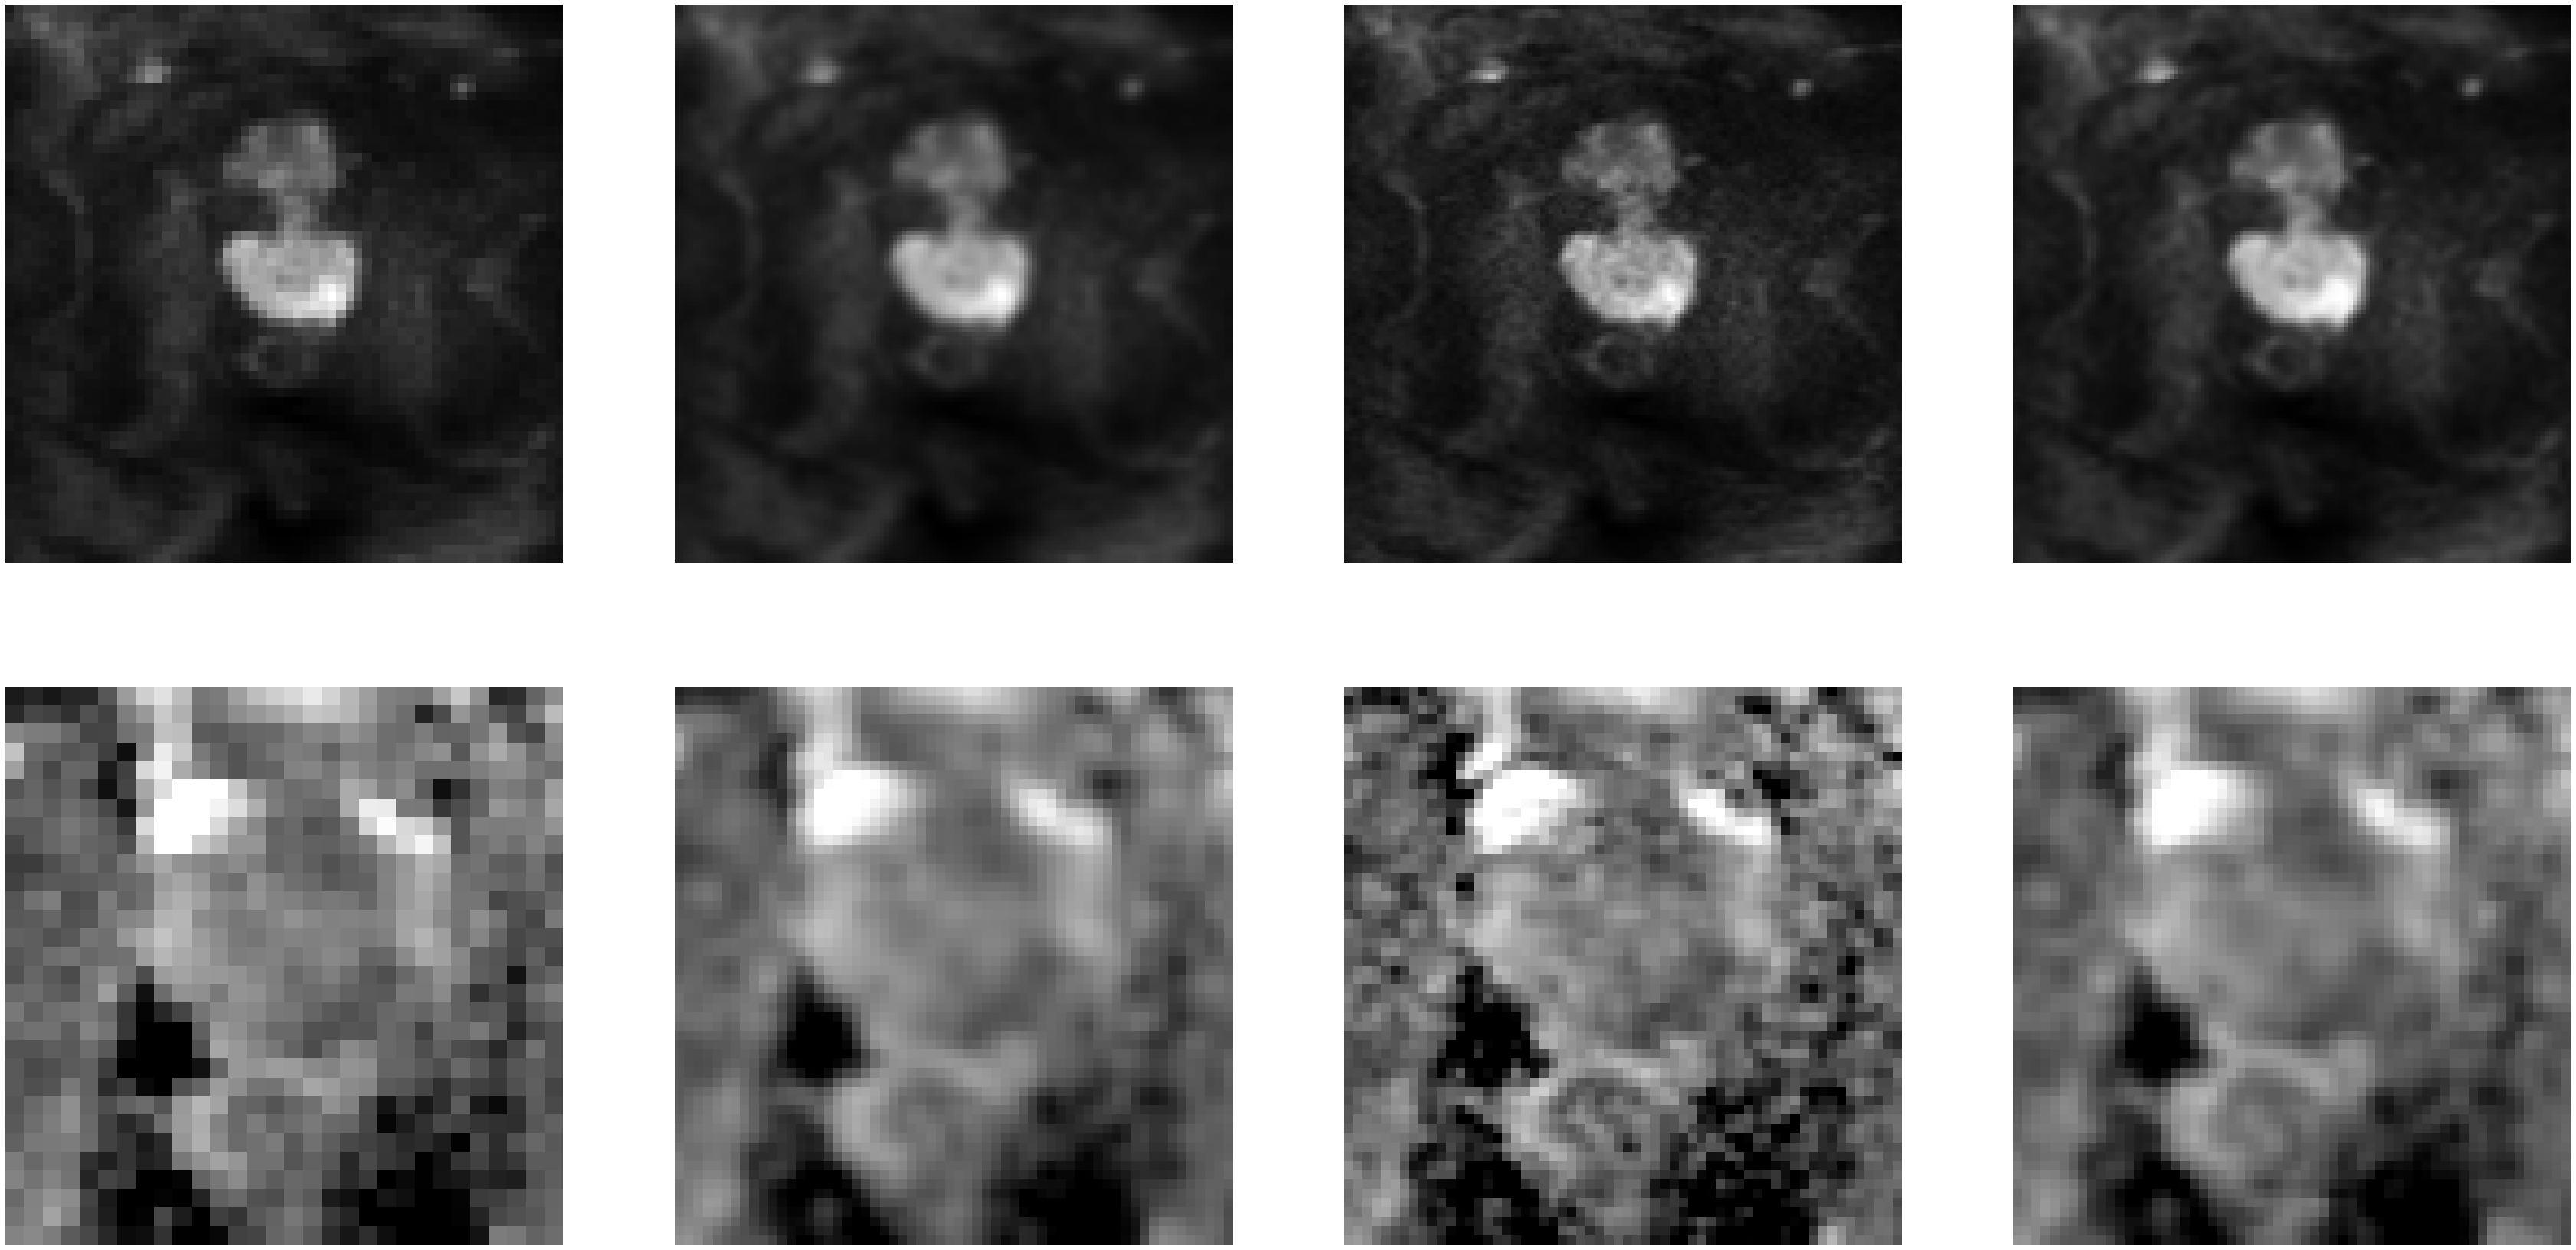

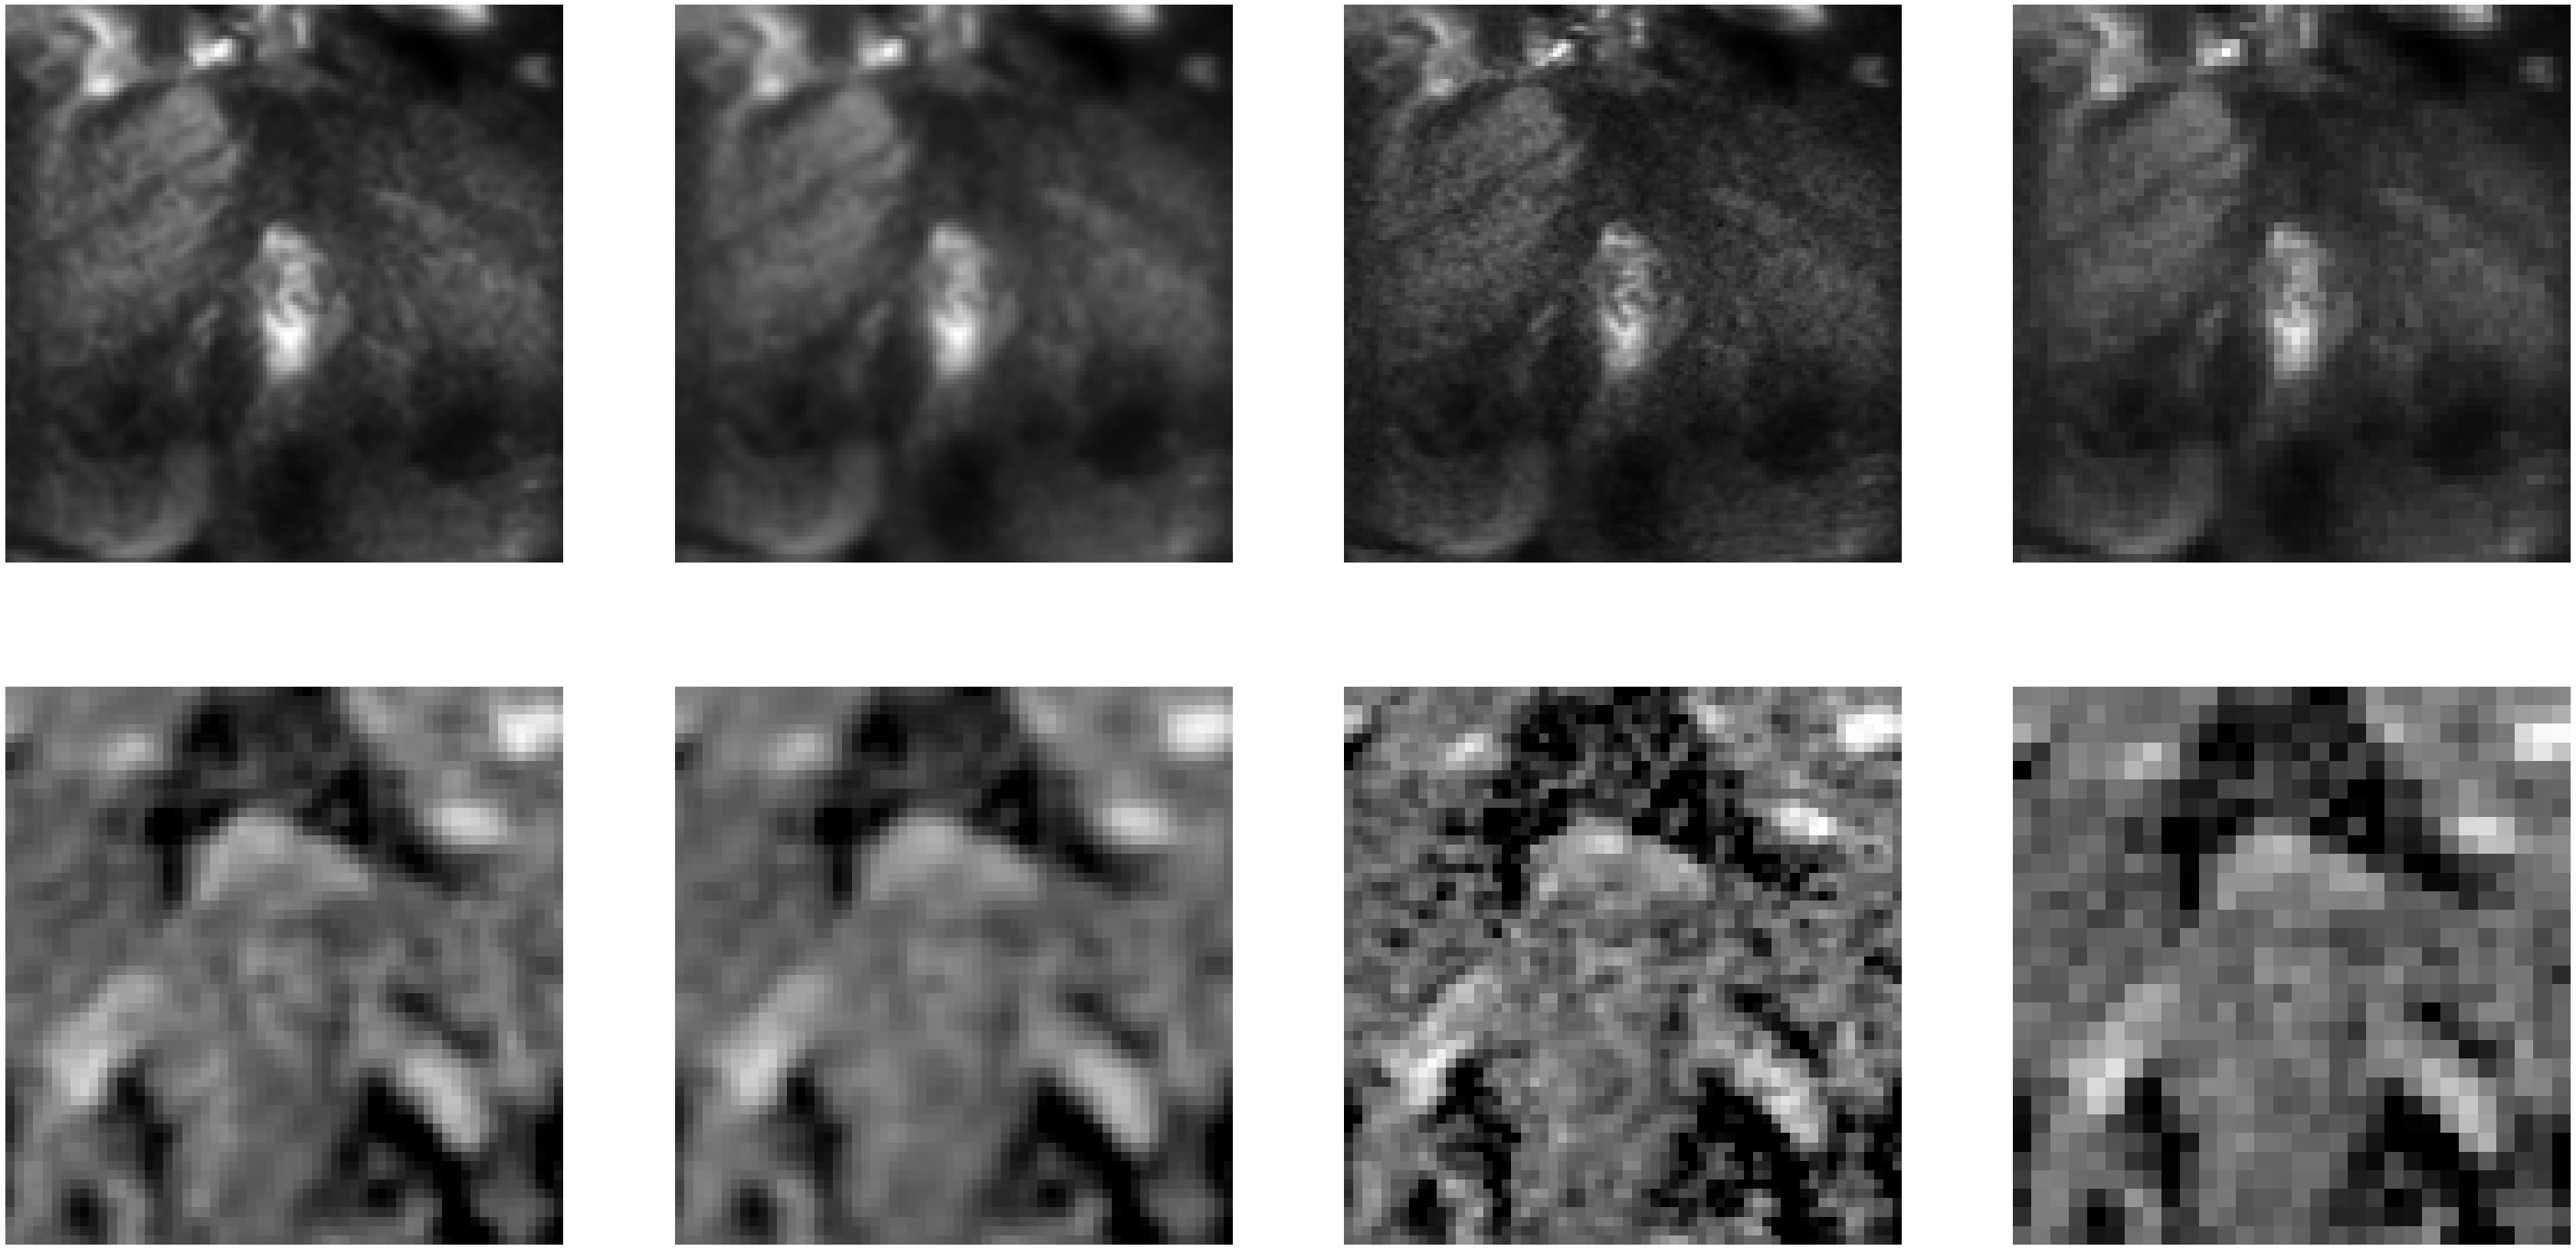

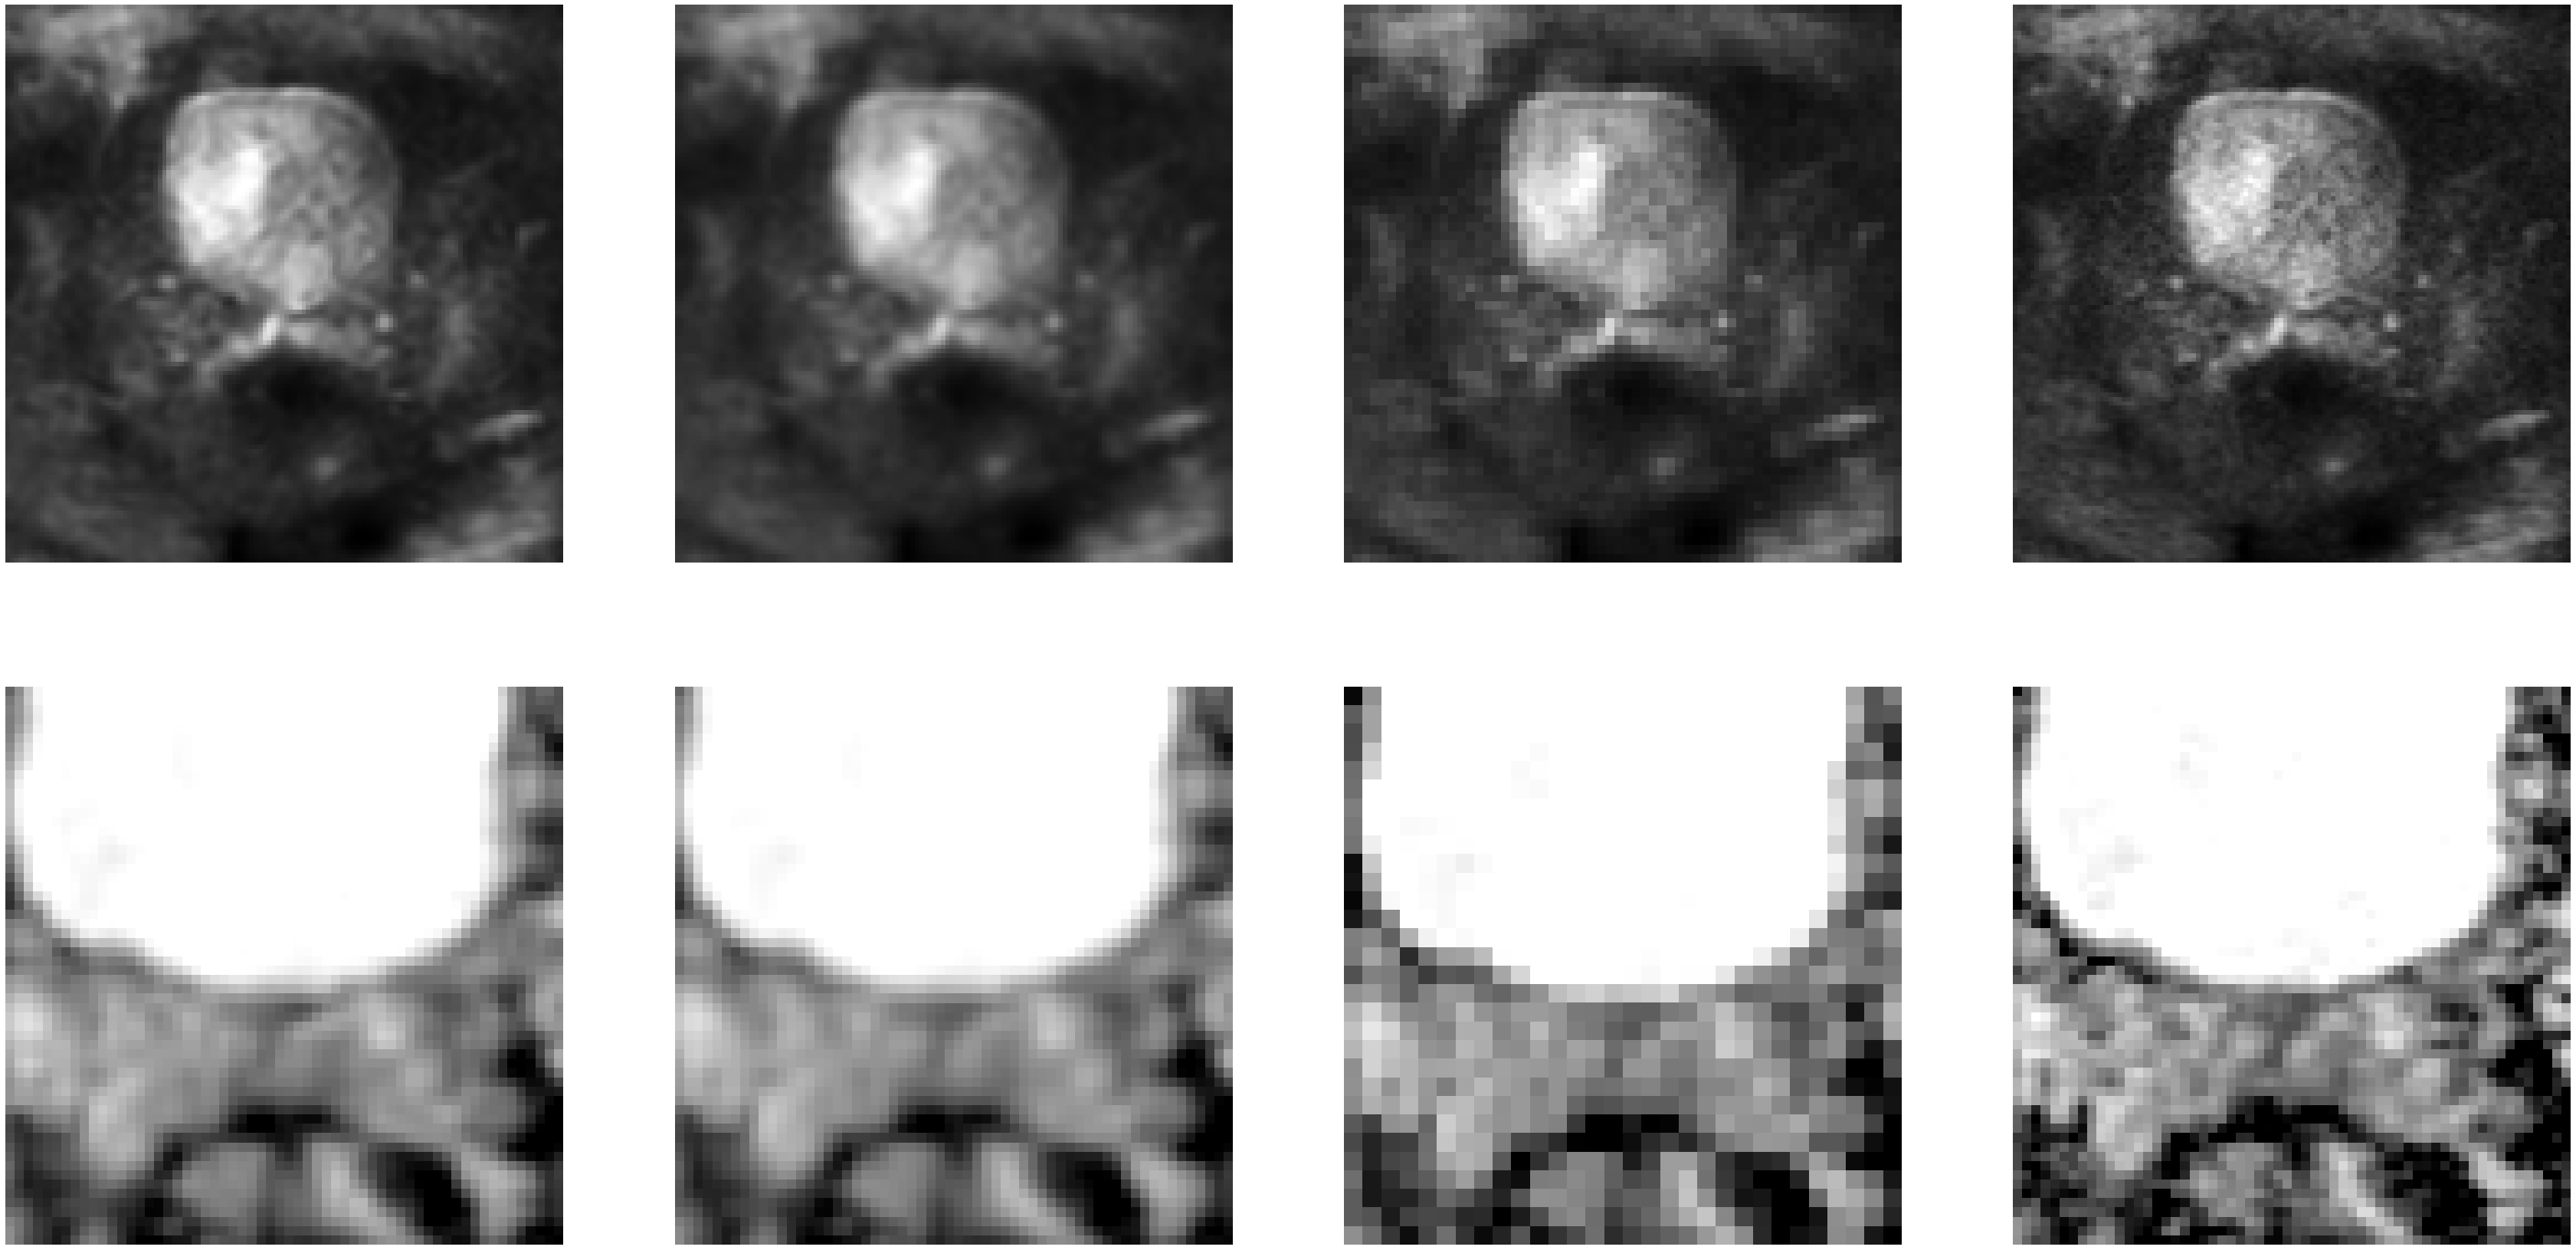

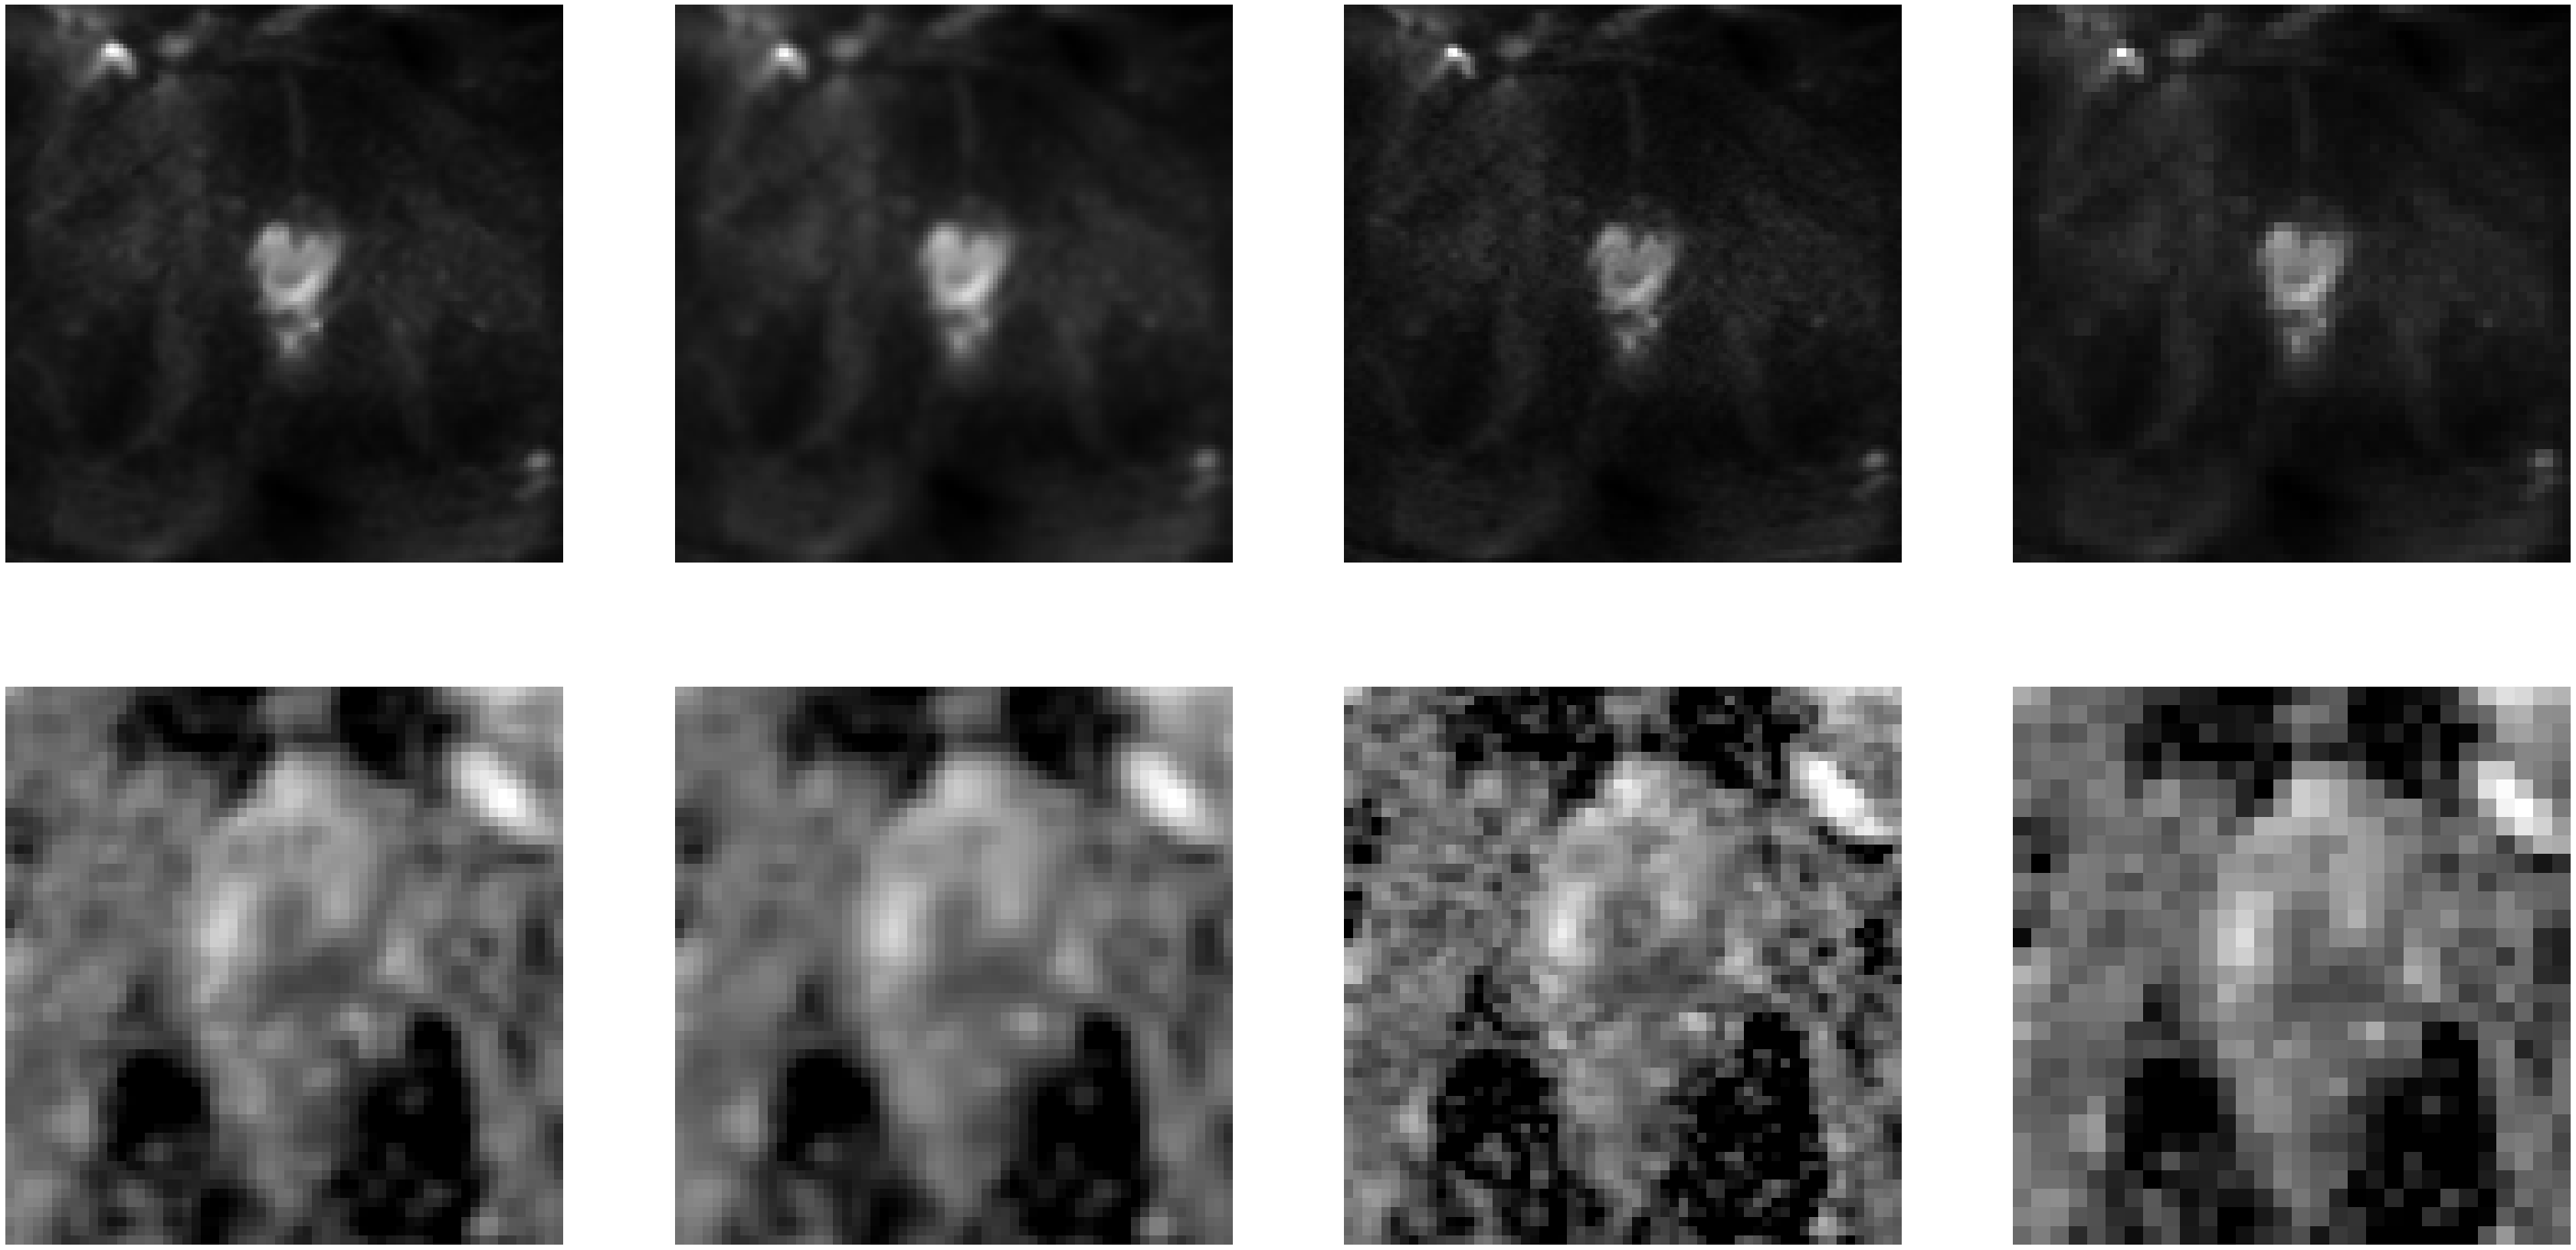

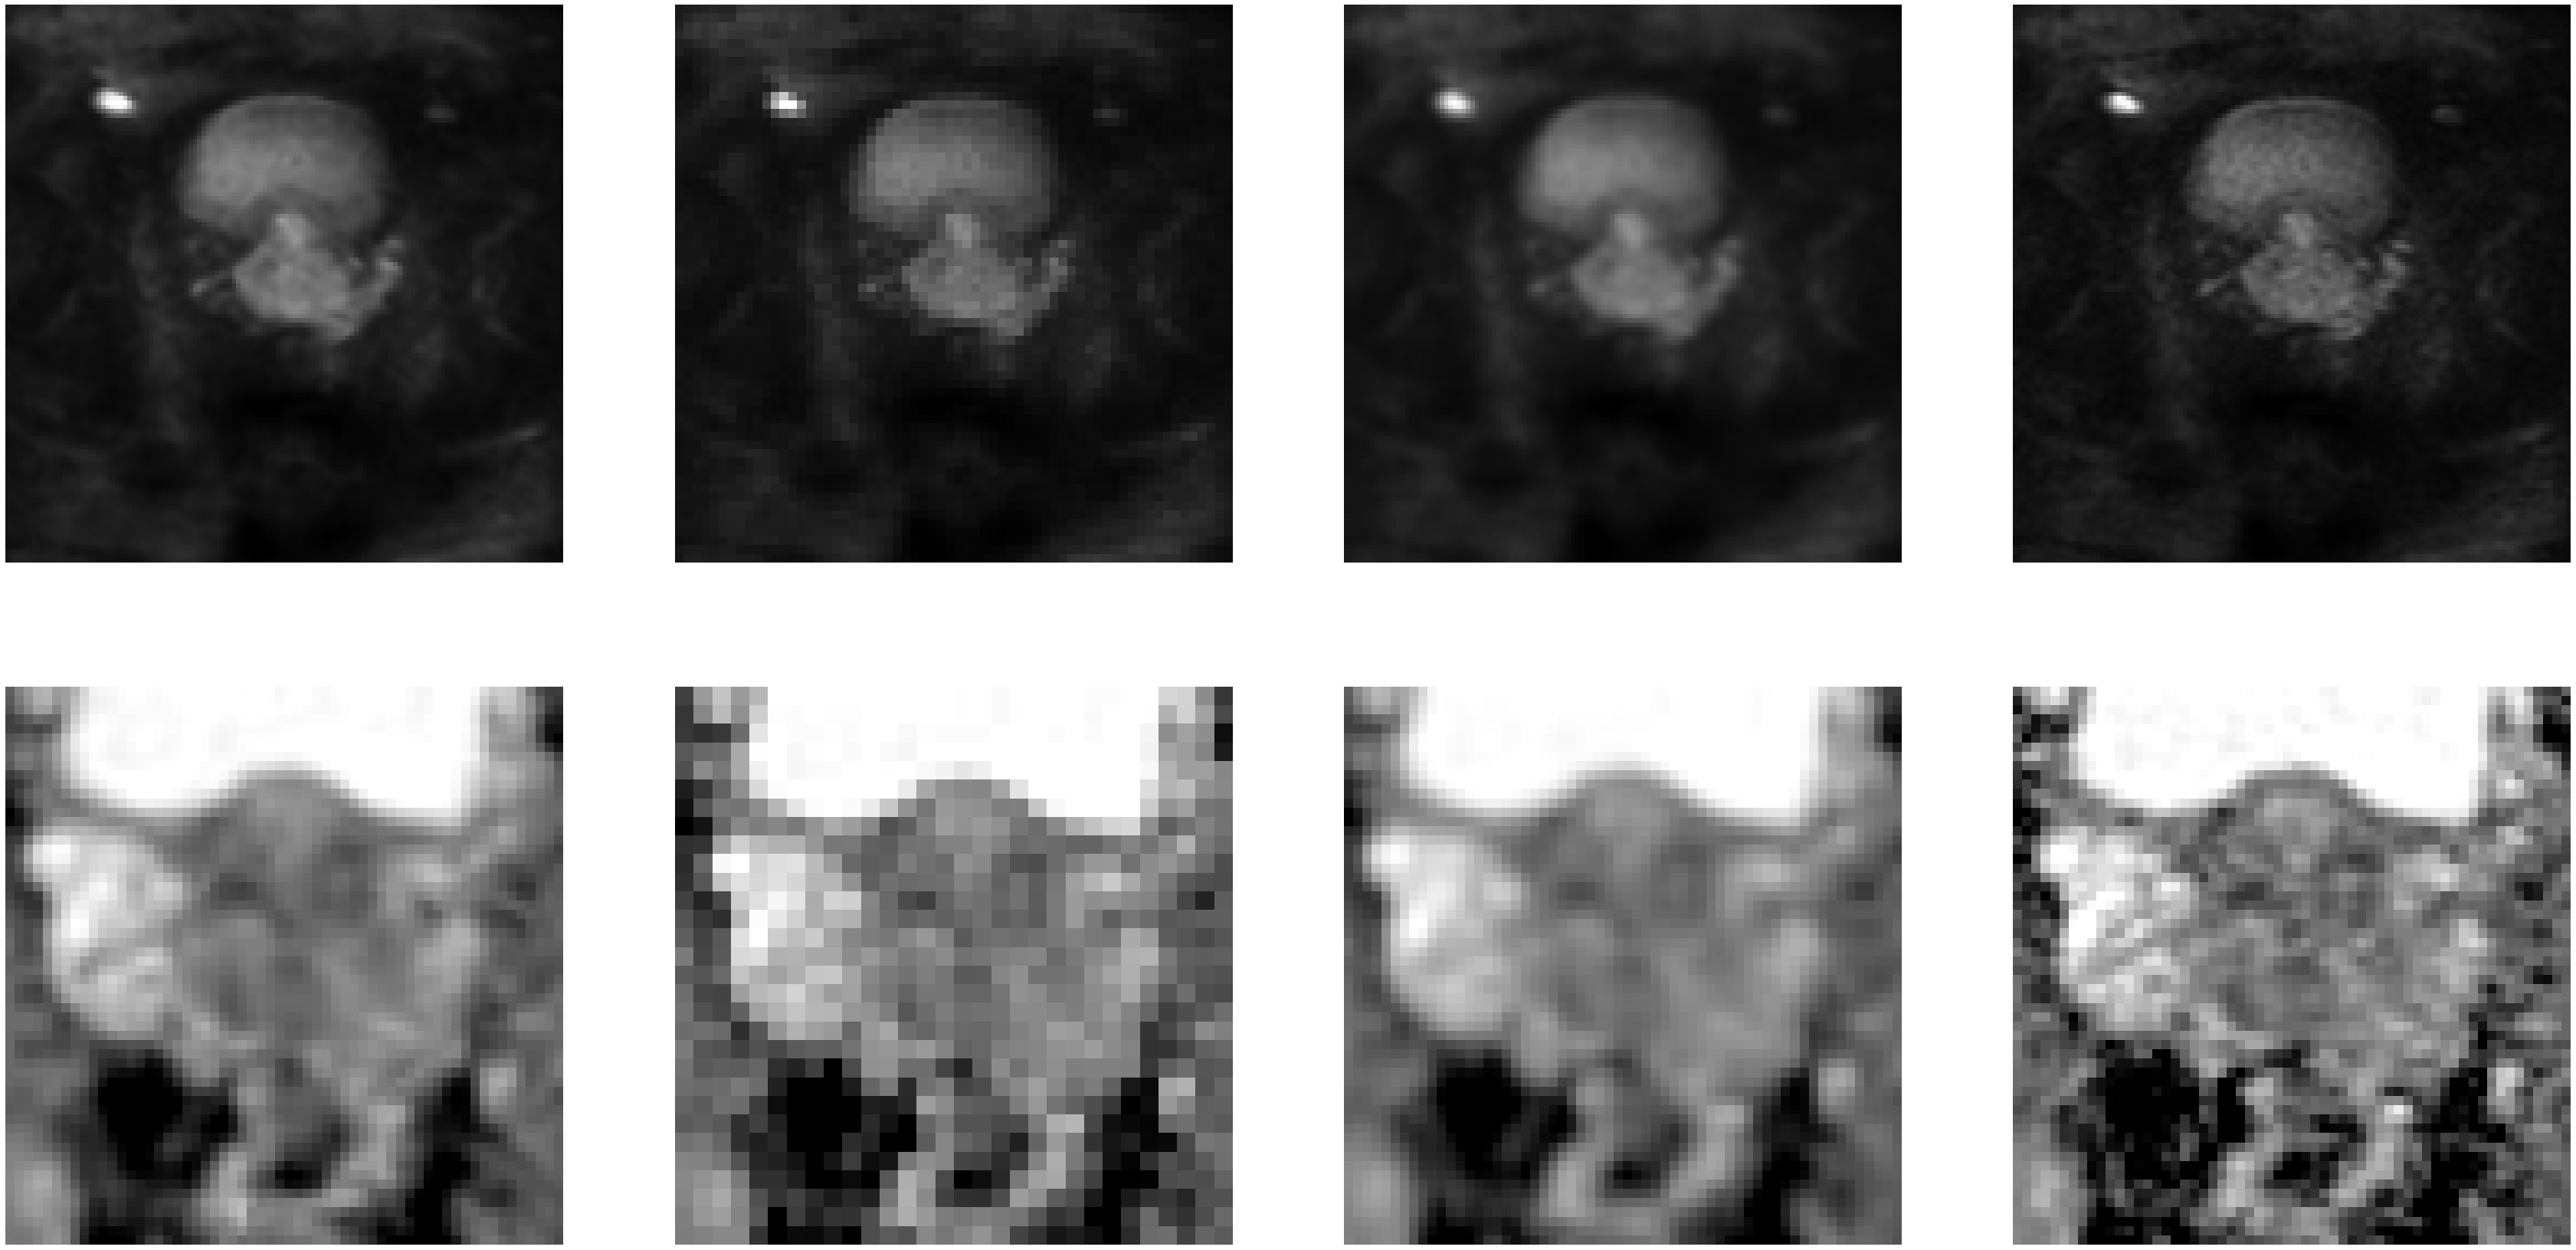

In [24]:
import random
import pandas as pd
output = pd.DataFrame()
_counter = 291
for case_no in range(10):
    case = cases[case_no]
    _slices = random.sample(list(range(case.b3.shape[2])), case.b3.shape[2])
    for _slice in _slices:#case.cancer_slice
        b = case.b[3]
        b0 = case.b0[:, :, _slice]
        dwi = case.b3[:, :, _slice, :]

        img = np.mean(dwi,-1)
        img_low = rescale(img, .5, anti_aliasing=True)
        img_dataset = [Image.fromarray(img_low)]
        dataset = ImageFitting_set(img_dataset)
        transform = Compose([ToTensor()])
        img_siren = Siren(in_features=2, out_features=1, 
                              hidden_features=128,
                              hidden_layers=3)
        img_siren.cuda()
        torch.cuda.empty_cache()
        optim = torch.optim.Adam(lr=3e-4, params=img_siren.parameters())

        ctr = 1
        _loss = 1000
        print('pre-training IRN')
        while(_loss > 0.00002):
            ground_truth, model_input  = dataset.pixels[0], dataset.coords[0]
            ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
            model_output = img_siren(model_input)
            loss = (model_output - ground_truth)**2
            loss = loss.mean()
            optim.zero_grad()
            loss.backward()
            optim.step()
            _loss = loss.item()
            if not model_output.cpu().view(64,64).detach().numpy().max():
                img_siren = Siren(in_features=2, out_features=1, 
                              hidden_features=128,
                              hidden_layers=3)
                img_siren.cuda()
                torch.cuda.empty_cache()
                optim = torch.optim.Adam(lr=3e-4, params=img_siren.parameters())
            if not ctr%500:
                print(_loss, ctr)
            ctr +=1
        PATH = 'model.pt'
        torch.save(img_siren.state_dict(), PATH)

        img_siren = Siren(in_features=2, out_features=1, 
                              hidden_features=128,
                              hidden_layers=3, perturb=True)
        PATH = 'model.pt'
        img_siren.load_state_dict(torch.load(PATH))
        img_siren.cuda()

        img_low_all = np.zeros((64, 64, case.b3.shape[2], case.b3.shape[3]))
        for i in range(case.b3.shape[3]):
            img_low_all[:,:, _slice, i] = rescale(case.b3[:, :, _slice, i], 0.5, anti_aliasing=True)
        accept = np.ones((img_low_all.shape))
        noise_center = case.noise
        noise_level = np.std(case.b3[noise_center[0]-3:noise_center[0]+2, 
                                          noise_center[1]-3:noise_center[1]+2,
                                          case.cancer_slice])/np.sqrt(2-np.pi/2)

        accept = (1/img_low_all.shape[-1])*np.ones((img_low_all.shape))
        mul, slope = 1000, 20
        b0_low = rescale(b0, .5, anti_aliasing=True)
        print('Conducting Soft-ERD and calculating weights...')
        for i in range(img_low_all.shape[0]):
            for j in range(img_low_all.shape[1]):
                x = img_low_all[i, j, _slice, :]
                b_zero = b0_low[i,j]
                if np.mean(x)>2*noise_level:
                    temp = max(mul*np.exp(-slope*(np.mean(x)/b_zero)), 2) #if temp is larger than 2, gives floating error (check later)
                    try:
                        w = np.exp(x/temp)
                    except RuntimeWarning:
                        w = onehot(x)
                    accept[i,j, _slice,:] = w

        accept_weights = []
        img_dataset = []
        for acq in range(case.b3.shape[3]):
            _accept = accept[:, :, _slice, acq]
            img = img_low_all[:, :, _slice, acq]    
            accept_weights.append(_accept)
            img_dataset.append(Image.fromarray(img))
        dataset = ImageFitting_set(img_dataset)
        _accept_weights = torch.empty((len(img_dataset), dataset.shape[0]**2, 1))
        for ctr, accept in enumerate(accept_weights):
            transform = Compose([ToTensor()])
            accept = transform(accept)
            _accept_weights [ctr] = accept.permute(1, 2, 0).view(-1, 1)

        params1 = list(img_siren.perturb_linear.parameters()) + list(img_siren.perturb_linear2.parameters())
        optim1 = torch.optim.Adam(lr=0.00001, params=params1)
        params2 = list(img_siren.net.parameters()) + list(img_siren.final_linear.parameters())
        optim2 = torch.optim.Adam(lr=0.0000001, params=params2)
        ctr = 0
        new_loss = 1000

        while True:
            mean_recon = np.zeros((64, 64))
            for sample in range(case.b3.shape[3]):
                ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
                ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
                model_output = img_siren(model_input, sample, 1.0/128.)
                mean_recon += model_output.cpu().view(64,64).detach().numpy()
                if not sample:
                    loss = (_accept_weights[sample].cuda()*(model_output - ground_truth)**2).mean()
                else:
                    loss += (_accept_weights[sample].cuda()*(model_output - ground_truth)**2).mean()   
            mean_recon /= case.b3.shape[3]
            optim1.zero_grad()

            optim2.zero_grad()
            loss.backward()
            optim1.step()
            optim2.step()
            if ctr>500:
                break      
            else:
                new_loss = loss.item()
            ctr +=1

        img = b0
        b0_low = rescale(img, .5, anti_aliasing=True)  
        big_size = 128
        big_mean = np.zeros((big_size,big_size))
        model_input  = get_mgrid(big_size, 2).cuda()
        for i in range(case.b3.shape[3]):
            big_mean += img_siren(model_input, i, 1.0/128).cpu().view(big_size,big_size).detach().numpy()
        big_mean /= case.b3.shape[3]
        adc_superres = calc_adc(big_mean, rescale(b0_low, 2, anti_aliasing=True),case.b[3])
        adc_low = calc_adc(img_low, b0_low, case.b[3])
        adc_interpolated = calc_adc(rescale(img_low, 2, anti_aliasing=True),
                                    rescale(b0_low, 2, anti_aliasing=True),
                                    case.b[3])
        adc_gold = calc_adc(np.mean(dwi,-1), case.b0[:,:,_slice],
                                    case.b[3])

        fig, axes = plt.subplots(2,4, figsize=(60,30))
        m = random.sample(list(range(4)), 4)
        axes[0][m[0]].imshow(img_low, cmap='gray')
        axes[1][m[0]].imshow(adc_low[35//2:95//2, 35//2:95//2], cmap='gray', vmin=0,vmax=3)
        axes[0][m[1]].imshow(rescale(img_low, 2, anti_aliasing=True),cmap='gray')
        axes[1][m[1]].imshow(adc_interpolated[35:95, 35:95],cmap='gray', vmin=0,vmax=3)
        axes[0][m[2]].imshow(big_mean, cmap='gray')
        axes[1][m[2]].imshow(adc_superres[35:95, 35:95], cmap='gray', vmin=0,vmax=3)
        axes[0][m[3]].imshow(np.mean(dwi,-1), cmap='gray')
        axes[1][m[3]].imshow(adc_gold[35:95, 35:95], cmap='gray', vmin=0,vmax=3)
        dictionary = {"file": str(_counter), "pt":case.pt_id, "image": str(_slice), m[0]+1:"low",
                      m[1]+1:"interpolated", m[2]+1: "SR", m[3]+1:"base"}
        for i in range(4):
            axes[0][i].axis('off')
            axes[1][i].axis('off')
        fig_name = os.path.join('qual', str(_counter) + '.png')
        plt.savefig(fig_name)
        _counter += 1
        output = output.append(dictionary, ignore_index=True)
output.to_csv('qual/labels.csv')

In [21]:
case.pt_id

'18-1681-07'